In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from path import Path
import gc

import optuna

from sklearn.model_selection import StratifiedKFold

from scipy.special import erfinv

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC

from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation, LeakyReLU
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

2022-07-30 08:53:23.468514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 08:53:23.640147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 08:53:23.641024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
def gpu_cleanup(objects):
    if objects:
        del(objects)
    K.clear_session()
    gc.collect()

In [3]:
class Config:
    input_directory = Path('../input/porto-seguro-safe-driver-prediction')
    dae_batch_size = 128
    dae_num_epoch = 50
    dae_architecture = [1500, 1500, 1500]
    reuse_autoencoder = False

    batch_size = 128
    num_epoch = 150
    units = [64, 32]
    input_dropout=0.06
    dropout=0.08
    regL2=0.09
    activation='selu'
    
    cv_folds = 5
    nas = False
    random_state = 0
    
config = Config()

In [4]:
train = pd.read_csv(config.input_directory / 'train.csv', index_col='id')
test = pd.read_csv(config.input_directory / 'test.csv', index_col='id')
submission = pd.read_csv(config.input_directory / 'sample_submission.csv', index_col='id')

In [5]:
calc_features = [feat for feat in train.columns if "_calc" in feat]
cat_features = [feat for feat in train.columns if "_cat" in feat]

In [6]:
# Extracting target
target = train["target"].values
train = train.drop("target", axis="columns")

In [7]:
# Removing calc features
train = train.drop(calc_features, axis="columns")
test = test.drop(calc_features, axis="columns")

In [8]:
# Adding one-hot encoding of cat features
train = pd.get_dummies(train, columns=cat_features)
test = pd.get_dummies(test, columns=cat_features)

In [9]:
assert((train.columns==test.columns).all())

In [10]:
print("Applying GaussRank to columns: ", end='')
to_normalize = list()
for k, col in enumerate(train.columns):
    if '_bin' not in col and '_cat' not in col and '_missing' not in col:
        to_normalize.append(col)
print(to_normalize)

def to_gauss(x): return np.sqrt(2) * erfinv(x) 

def normalize(data, norm_cols):
    n = data.shape[0]
    for col in norm_cols:
        sorted_idx = data[col].sort_values().index.tolist()
        uniform = np.linspace(start=-0.99, stop=0.99, num=n)
        normal = to_gauss(uniform)
        normalized_col = pd.Series(index=sorted_idx, data=normal)
        data[col] = normalized_col
    return data

train = normalize(train, to_normalize)
test = normalize(test, to_normalize)

Applying GaussRank to columns: ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']


In [11]:
features = train.columns
train_index = train.index
test_index = test.index

train = train.values.astype(np.float32)
test = test.values.astype(np.float32)

In [12]:
def plot_keras_history(history, measures):
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        try:
            panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        except:
            pass
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

In [13]:
from numba import jit

@jit
def eval_gini(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_pred)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

In [14]:
def batch_generator(x, batch_size, shuffle=True, random_state=None):
    batch_index = 0
    n = x.shape[0]
    while True:
        if batch_index == 0:
            index_array = np.arange(n)
            if shuffle:
                np.random.seed(seed=random_state)
                index_array = np.random.permutation(n)

        current_index = (batch_index * batch_size) % n
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1
        else:
            current_batch_size = n - current_index
            batch_index = 0

        batch = x[index_array[current_index: current_index + current_batch_size]]

        yield batch


def mixup_generator(X, batch_size, swaprate=0.15, shuffle=True, random_state=None):
    if random_state is None:
        random_state = np.randint(0, 999)

    num_features = X.shape[1]
    num_swaps = int(num_features * swaprate)    
    generator_a = batch_generator(X, batch_size, shuffle, random_state)
    generator_b = batch_generator(X, batch_size, shuffle, random_state + 1)

    while True:
        batch = next(generator_a)
        mixed_batch = batch.copy()
        effective_batch_size = batch.shape[0]
        alternative_batch = next(generator_b)
        assert((batch != alternative_batch).any())
        for i in range(effective_batch_size):
            swap_idx = np.random.choice(num_features, num_swaps, replace=False)
            mixed_batch[i, swap_idx] = alternative_batch[i, swap_idx]
        yield (mixed_batch, batch)

def extract_dae_features(autoencoder, X, layers=[3]):
    data = []
    for layer in layers:
        if layer==0:
            data.append(X)
        else:
            get_layer_output = Model([autoencoder.layers[0].input], [autoencoder.layers[layer].output])
            layer_output = get_layer_output.predict(X, batch_size=128)
            data.append(layer_output)
    data = np.hstack(data)
    return data

def get_DAE(X, architecture=[1500, 1500, 1500]):
    features = X.shape[1]
    inputs = Input((features,))
    for i, nodes in enumerate(architecture):
        layer = Dense(nodes, activation='relu', use_bias=False, name=f"code_{i+1}")
        if i==0:
            x = layer(inputs)
        else:
            x = layer(x)
        x = BatchNormalization()(x)
    outputs = Dense(features, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    return model

def autoencoder_fitting(X_train, X_valid, filename='dae', random_state=None, suppress_output=False):
    if suppress_output:
        verbose = 0
    else:
        verbose = 2
        print("Fitting a denoising autoencoder")

    tf.random.set_seed(seed=random_state)
    generator = mixup_generator(X_train, 
                                batch_size=config.dae_batch_size, 
                                swaprate=0.15, 
                                random_state=config.random_state)
                                
    dae = get_DAE(X_train, architecture=config.dae_architecture)
    steps_per_epoch = np.ceil(X_train.shape[0] / config.dae_batch_size)

    early_stopping = EarlyStopping(monitor='val_mse', 
                                mode='min', 
                                patience=5, 
                                restore_best_weights=True,
                                verbose=0)

    history = dae.fit(generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=config.dae_num_epoch,
                    validation_data=(X_valid, X_valid),
                    callbacks=[early_stopping],
                    verbose=verbose)

    if not suppress_output: plot_keras_history(history, measures=['mse', 'mae'])

    dae.save(filename)

    return dae

In [15]:
def dense_blocks(x, units, activation, regL2, dropout):
    kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=config.random_state)
    for k, layer_units in enumerate(units):
        if regL2 > 0:
            x = Dense(layer_units, activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=l2(regL2))(x)
        else:
            x = Dense(layer_units, kernel_initializer=kernel_initializer, activation=activation)(x)
        if dropout > 0:
            x = Dropout(dropout)(x)
    return x
        
def dnn_model(dae, units=[4500, 1000, 1000], 
            input_dropout=0.1, dropout=0.5,
            regL2=0.05,
            activation='relu'):
    
    inputs = dae.get_layer("code_2").output
    if input_dropout > 0:
        x = Dropout(input_dropout)(inputs)
    else:
        x = tf.keras.layers.Layer()(inputs)
    x = dense_blocks(x, units, activation, regL2, dropout)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=dae.input, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=keras.losses.binary_crossentropy,
                metrics=[AUC(name='auc')])
    return model

def model_fitting(X_train, y_train, X_valid, y_valid, autoencoder, filename, random_state=None, suppress_output=False):
        if suppress_output:
            verbose = 0
        else:
            verbose = 2
            print("Fitting model")

        early_stopping = EarlyStopping(monitor='val_auc', 
                                    mode='max', 
                                    patience=10, 
                                    restore_best_weights=True,
                                    verbose=0)

        rlrop = ReduceLROnPlateau(monitor='val_auc', 
                                mode='max',
                                patience=2,
                                factor=0.75,
                                verbose=0)
        
        tf.random.set_seed(seed=random_state)

        model = dnn_model(autoencoder,
                    units=config.units,
                    input_dropout=config.input_dropout,
                    dropout=config.dropout,
                    regL2=config.regL2,
                    activation=config.activation)
        
        history = model.fit(X_train, y_train, 
                            epochs=config.num_epoch, 
                            batch_size=config.batch_size, 
                            validation_data=(X_valid, y_valid),
                            callbacks=[early_stopping, rlrop],
                            shuffle=True,
                            verbose=verbose)

        model.save(filename)
        
        if not suppress_output:  plot_keras_history(history, measures=['loss', 'auc'])

        return model, history

In [16]:
if config.nas is True:
    def evaluate():
        metric_evaluations = list()

        skf = StratifiedKFold(n_splits=config.cv_folds, shuffle=True, random_state=config.random_state)

        for k, (train_idx, valid_idx) in enumerate(skf.split(train, target)):
            
            X_train, y_train = train[train_idx, :], target[train_idx]
            X_valid, y_valid = train[valid_idx, :], target[valid_idx]

            if config.reuse_autoencoder:
                autoencoder = load_model(f"./dae_fold_{k}")
            else:
                autoencoder = autoencoder_fitting(X_train, X_valid,
                                                filename=f'./dae_fold_{k}', 
                                                random_state=config.random_state,
                                                suppress_output=True)
            
            model, _ = model_fitting(X_train, y_train, X_valid, y_valid,
                                        autoencoder=autoencoder,
                                        filename=f"dnn_model_fold_{k}", 
                                        random_state=config.random_state,
                                        suppress_output=True)
            
            val_preds = model.predict(X_valid, batch_size=128, verbose=0)
            best_score = eval_gini(y_true=y_valid, y_pred=np.ravel(val_preds))
            metric_evaluations.append(best_score)
            
            gpu_cleanup([autoencoder, model])
        
        return np.mean(metric_evaluations)

    def objective(trial):
        params = {
                'first_layer': trial.suggest_categorical("first_layer", [8, 16, 32, 64, 128, 256, 512]),
                'second_layer': trial.suggest_categorical("second_layer", [0, 8, 16, 32, 64, 128, 256]),
                'third_layer': trial.suggest_categorical("third_layer", [0, 8, 16, 32, 64, 128, 256]),
                'input_dropout': trial.suggest_float("input_dropout", 0.0, 0.5),
                'dropout': trial.suggest_float("dropout", 0.0, 0.5),
                'regL2': trial.suggest_uniform("regL2", 0.0, 0.1),
                'activation': trial.suggest_categorical("activation", ['relu', 'leaky-relu', 'selu'])
        }

        config.units = [nodes for nodes in [params['first_layer'], params['second_layer'], params['third_layer']] if nodes > 0]
        config.input_dropout = params['input_dropout']
        config.dropout = params['dropout']
        config.regL2 = params['regL2']
        config.activation = params['activation']
        
        return evaluate()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=60)

    print("Best Gini Normalized Score", study.best_value)
    print("Best parameters", study.best_params)

    config.units = [nodes for nodes in [study.best_params['first_layer'], study.best_params['second_layer'], study.best_params['third_layer']] if nodes > 0]
    config.input_dropout = study.best_params['input_dropout']
    config.dropout = study.best_params['dropout']
    config.regL2 = study.best_params['regL2']
    config.activation = study.best_params['activation']

CV fold 0
Fitting a denoising autoencoder


2022-07-30 08:53:49.365131: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-30 08:53:49.365657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 08:53:49.366551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 08:53:49.367231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Epoch 1/50
3721/3721 - 32s - loss: 0.0328 - mse: 0.0328 - mae: 0.0911 - val_loss: 0.0276 - val_mse: 0.0276 - val_mae: 0.1041
Epoch 2/50
3721/3721 - 29s - loss: 0.0225 - mse: 0.0225 - mae: 0.0672 - val_loss: 0.0204 - val_mse: 0.0204 - val_mae: 0.0750
Epoch 3/50
3721/3721 - 34s - loss: 0.0198 - mse: 0.0198 - mae: 0.0571 - val_loss: 0.0162 - val_mse: 0.0162 - val_mae: 0.0640
Epoch 4/50
3721/3721 - 30s - loss: 0.0181 - mse: 0.0181 - mae: 0.0514 - val_loss: 0.0135 - val_mse: 0.0135 - val_mae: 0.0568
Epoch 5/50
3721/3721 - 34s - loss: 0.0169 - mse: 0.0169 - mae: 0.0478 - val_loss: 0.0098 - val_mse: 0.0098 - val_mae: 0.0490
Epoch 6/50
3721/3721 - 29s - loss: 0.0159 - mse: 0.0159 - mae: 0.0451 - val_loss: 0.0056 - val_mse: 0.0056 - val_mae: 0.0383
Epoch 7/50
3721/3721 - 29s - loss: 0.0152 - mse: 0.0152 - mae: 0.0430 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0292
Epoch 8/50
3721/3721 - 34s - loss: 0.0147 - mse: 0.0147 - mae: 0.0410 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0260


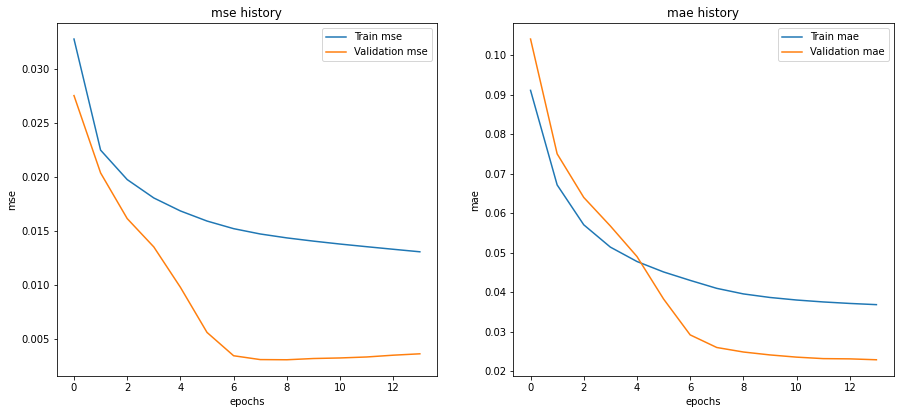

2022-07-30 09:01:03.773799: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Fitting model
Epoch 1/150
3721/3721 - 17s - loss: 1.8743 - auc: 0.5673 - val_loss: 0.1628 - val_auc: 0.6286
Epoch 2/150
3721/3721 - 15s - loss: 0.1601 - auc: 0.6040 - val_loss: 0.1593 - val_auc: 0.6359
Epoch 3/150
3721/3721 - 16s - loss: 0.1576 - auc: 0.6200 - val_loss: 0.1547 - val_auc: 0.6394
Epoch 4/150
3721/3721 - 15s - loss: 0.1562 - auc: 0.6300 - val_loss: 0.1582 - val_auc: 0.6406
Epoch 5/150
3721/3721 - 16s - loss: 0.1549 - auc: 0.6480 - val_loss: 0.1567 - val_auc: 0.6345
Epoch 6/150
3721/3721 - 15s - loss: 0.1538 - auc: 0.6601 - val_loss: 0.1556 - val_auc: 0.6314
Epoch 7/150
3721/3721 - 16s - loss: 0.1509 - auc: 0.6903 - val_loss: 0.1568 - val_auc: 0.6143
Epoch 8/150
3721/3721 - 15s - loss: 0.1487 - auc: 0.7142 - val_loss: 0.1639 - val_auc: 0.6068
Epoch 9/150
3721/3721 - 16s - loss: 0.1444 - auc: 0.7457 - val_loss: 0.1724 - val_auc: 0.6047
Epoch 10/150
3721/3721 - 15s - loss: 0.1414 - auc: 0.7672 - val_loss: 0.1647 - val_auc: 0.5916
Epoch 11/150
3721/3721 - 16s - loss: 0.1363 -

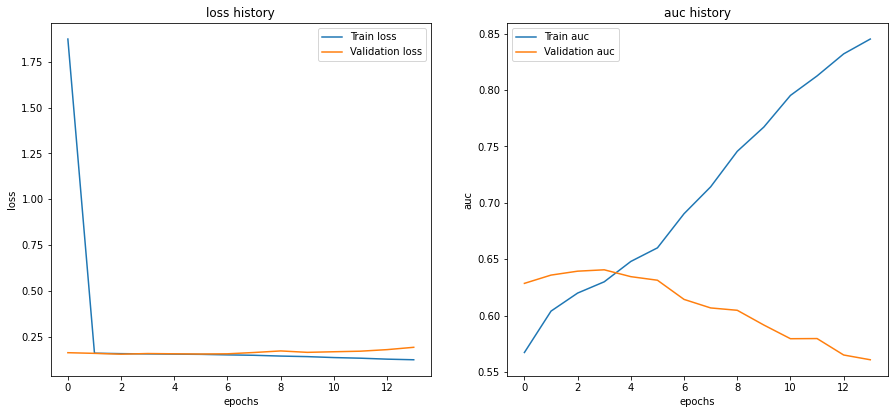

[best epoch is 4]	validation_0-gini_dnn: 0.28354



2022-07-30 09:04:50.355858: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 739251648 exceeds 10% of free system memory.
2022-07-30 09:04:51.113686: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 739251648 exceeds 10% of free system memory.


CV fold 1
Fitting a denoising autoencoder
Epoch 1/50
3721/3721 - 34s - loss: 0.0326 - mse: 0.0326 - mae: 0.0905 - val_loss: 0.0227 - val_mse: 0.0227 - val_mae: 0.0875
Epoch 2/50
3721/3721 - 33s - loss: 0.0226 - mse: 0.0226 - mae: 0.0675 - val_loss: 0.0167 - val_mse: 0.0167 - val_mae: 0.0695
Epoch 3/50
3721/3721 - 33s - loss: 0.0199 - mse: 0.0199 - mae: 0.0583 - val_loss: 0.0115 - val_mse: 0.0115 - val_mae: 0.0554
Epoch 4/50
3721/3721 - 29s - loss: 0.0181 - mse: 0.0181 - mae: 0.0517 - val_loss: 0.0086 - val_mse: 0.0086 - val_mae: 0.0461
Epoch 5/50
3721/3721 - 33s - loss: 0.0169 - mse: 0.0169 - mae: 0.0477 - val_loss: 0.0059 - val_mse: 0.0059 - val_mae: 0.0393
Epoch 6/50
3721/3721 - 33s - loss: 0.0160 - mse: 0.0160 - mae: 0.0449 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0332
Epoch 7/50
3721/3721 - 33s - loss: 0.0153 - mse: 0.0153 - mae: 0.0427 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0288
Epoch 8/50
3721/3721 - 29s - loss: 0.0148 - mse: 0.0148 - mae: 0.0408 - val_loss: 0

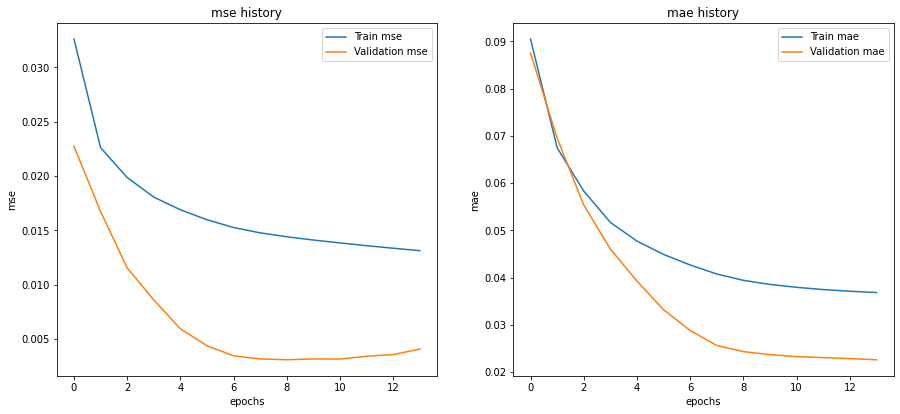

Fitting model
Epoch 1/150
3721/3721 - 17s - loss: 1.8630 - auc: 0.5705 - val_loss: 0.1584 - val_auc: 0.6154
Epoch 2/150
3721/3721 - 15s - loss: 0.1599 - auc: 0.6042 - val_loss: 0.1578 - val_auc: 0.6173
Epoch 3/150
3721/3721 - 16s - loss: 0.1571 - auc: 0.6243 - val_loss: 0.1559 - val_auc: 0.6269
Epoch 4/150
3721/3721 - 15s - loss: 0.1558 - auc: 0.6374 - val_loss: 0.1598 - val_auc: 0.6170
Epoch 5/150
3721/3721 - 16s - loss: 0.1544 - auc: 0.6548 - val_loss: 0.1557 - val_auc: 0.6197
Epoch 6/150
3721/3721 - 15s - loss: 0.1519 - auc: 0.6796 - val_loss: 0.1569 - val_auc: 0.6061
Epoch 7/150
3721/3721 - 16s - loss: 0.1498 - auc: 0.7042 - val_loss: 0.1602 - val_auc: 0.6082
Epoch 8/150
3721/3721 - 15s - loss: 0.1466 - auc: 0.7302 - val_loss: 0.1591 - val_auc: 0.5907
Epoch 9/150
3721/3721 - 16s - loss: 0.1434 - auc: 0.7548 - val_loss: 0.1646 - val_auc: 0.5835
Epoch 10/150
3721/3721 - 15s - loss: 0.1390 - auc: 0.7820 - val_loss: 0.1751 - val_auc: 0.5732
Epoch 11/150
3721/3721 - 16s - loss: 0.1355 -

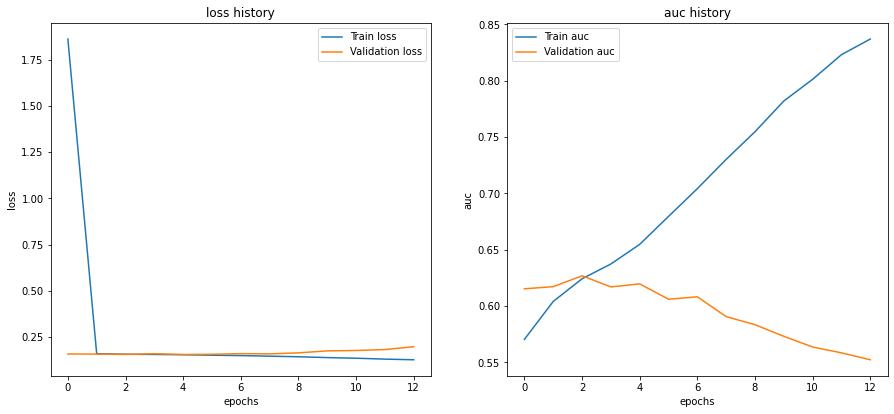

[best epoch is 3]	validation_0-gini_dnn: 0.25722



2022-07-30 09:16:05.014159: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 739251648 exceeds 10% of free system memory.
2022-07-30 09:16:05.756718: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 739251648 exceeds 10% of free system memory.


CV fold 2
Fitting a denoising autoencoder
Epoch 1/50
3721/3721 - 35s - loss: 0.0327 - mse: 0.0327 - mae: 0.0910 - val_loss: 0.0201 - val_mse: 0.0201 - val_mae: 0.0865
Epoch 2/50
3721/3721 - 29s - loss: 0.0225 - mse: 0.0225 - mae: 0.0664 - val_loss: 0.0198 - val_mse: 0.0198 - val_mae: 0.0764
Epoch 3/50
3721/3721 - 33s - loss: 0.0199 - mse: 0.0199 - mae: 0.0569 - val_loss: 0.0158 - val_mse: 0.0158 - val_mae: 0.0599
Epoch 4/50
3721/3721 - 29s - loss: 0.0182 - mse: 0.0182 - mae: 0.0513 - val_loss: 0.0128 - val_mse: 0.0128 - val_mae: 0.0543
Epoch 5/50
3721/3721 - 34s - loss: 0.0169 - mse: 0.0169 - mae: 0.0475 - val_loss: 0.0080 - val_mse: 0.0080 - val_mae: 0.0427
Epoch 6/50
3721/3721 - 33s - loss: 0.0159 - mse: 0.0159 - mae: 0.0444 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0323
Epoch 7/50
3721/3721 - 34s - loss: 0.0151 - mse: 0.0151 - mae: 0.0418 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0263
Epoch 8/50
3721/3721 - 33s - loss: 0.0146 - mse: 0.0146 - mae: 0.0400 - val_loss: 0

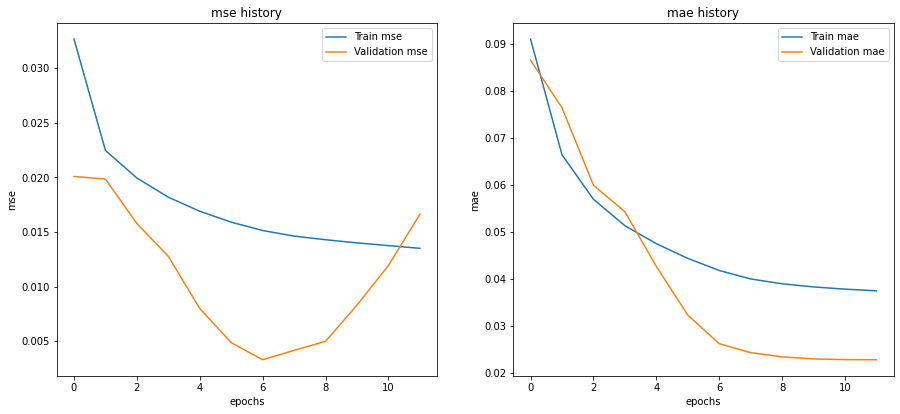

Fitting model
Epoch 1/150
3721/3721 - 16s - loss: 1.8122 - auc: 0.5707 - val_loss: 0.1586 - val_auc: 0.6243
Epoch 2/150
3721/3721 - 15s - loss: 0.1592 - auc: 0.6108 - val_loss: 0.1563 - val_auc: 0.6216
Epoch 3/150
3721/3721 - 15s - loss: 0.1573 - auc: 0.6182 - val_loss: 0.1582 - val_auc: 0.6308
Epoch 4/150
3721/3721 - 16s - loss: 0.1560 - auc: 0.6331 - val_loss: 0.1549 - val_auc: 0.6322
Epoch 5/150
3721/3721 - 15s - loss: 0.1548 - auc: 0.6484 - val_loss: 0.1552 - val_auc: 0.6276
Epoch 6/150
3721/3721 - 15s - loss: 0.1535 - auc: 0.6643 - val_loss: 0.1615 - val_auc: 0.6247
Epoch 7/150
3721/3721 - 15s - loss: 0.1506 - auc: 0.6946 - val_loss: 0.1614 - val_auc: 0.6074
Epoch 8/150
3721/3721 - 15s - loss: 0.1484 - auc: 0.7169 - val_loss: 0.1573 - val_auc: 0.6029
Epoch 9/150
3721/3721 - 15s - loss: 0.1443 - auc: 0.7477 - val_loss: 0.1581 - val_auc: 0.5969
Epoch 10/150
3721/3721 - 15s - loss: 0.1412 - auc: 0.7705 - val_loss: 0.1684 - val_auc: 0.5955
Epoch 11/150
3721/3721 - 15s - loss: 0.1362 -

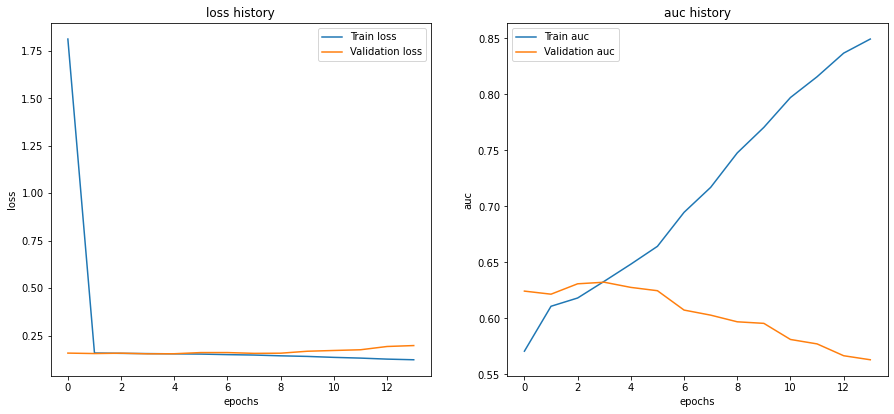

[best epoch is 4]	validation_0-gini_dnn: 0.26824



2022-07-30 09:27:21.240382: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 739251648 exceeds 10% of free system memory.


CV fold 3
Fitting a denoising autoencoder
Epoch 1/50
3721/3721 - 30s - loss: 0.0326 - mse: 0.0326 - mae: 0.0917 - val_loss: 0.0237 - val_mse: 0.0237 - val_mae: 0.0940
Epoch 2/50
3721/3721 - 33s - loss: 0.0222 - mse: 0.0222 - mae: 0.0673 - val_loss: 0.0181 - val_mse: 0.0181 - val_mae: 0.0712
Epoch 3/50
3721/3721 - 29s - loss: 0.0195 - mse: 0.0195 - mae: 0.0574 - val_loss: 0.0125 - val_mse: 0.0125 - val_mae: 0.0546
Epoch 4/50
3721/3721 - 33s - loss: 0.0177 - mse: 0.0177 - mae: 0.0510 - val_loss: 0.0085 - val_mse: 0.0085 - val_mae: 0.0434
Epoch 5/50
3721/3721 - 28s - loss: 0.0165 - mse: 0.0165 - mae: 0.0464 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0336
Epoch 6/50
3721/3721 - 33s - loss: 0.0156 - mse: 0.0156 - mae: 0.0430 - val_loss: 0.0034 - val_mse: 0.0034 - val_mae: 0.0275
Epoch 7/50
3721/3721 - 29s - loss: 0.0149 - mse: 0.0149 - mae: 0.0406 - val_loss: 0.0029 - val_mse: 0.0029 - val_mae: 0.0244
Epoch 8/50
3721/3721 - 34s - loss: 0.0145 - mse: 0.0145 - mae: 0.0392 - val_loss: 0

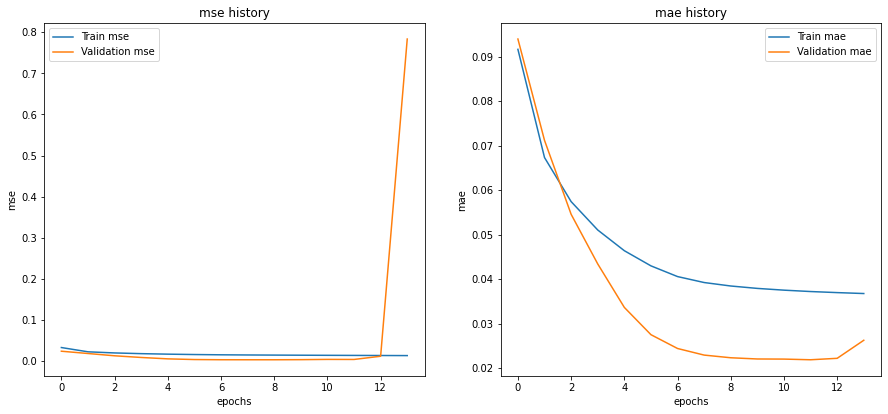

Fitting model
Epoch 1/150
3721/3721 - 16s - loss: 1.8143 - auc: 0.5674 - val_loss: 0.1572 - val_auc: 0.6388
Epoch 2/150
3721/3721 - 16s - loss: 0.1600 - auc: 0.6034 - val_loss: 0.1569 - val_auc: 0.6408
Epoch 3/150
3721/3721 - 15s - loss: 0.1575 - auc: 0.6179 - val_loss: 0.1548 - val_auc: 0.6427
Epoch 4/150
3721/3721 - 15s - loss: 0.1563 - auc: 0.6302 - val_loss: 0.1556 - val_auc: 0.6492
Epoch 5/150
3721/3721 - 16s - loss: 0.1549 - auc: 0.6484 - val_loss: 0.1562 - val_auc: 0.6425
Epoch 6/150
3721/3721 - 15s - loss: 0.1537 - auc: 0.6661 - val_loss: 0.1573 - val_auc: 0.6342
Epoch 7/150
3721/3721 - 16s - loss: 0.1506 - auc: 0.6953 - val_loss: 0.1578 - val_auc: 0.6174
Epoch 8/150
3721/3721 - 15s - loss: 0.1482 - auc: 0.7196 - val_loss: 0.1561 - val_auc: 0.6120
Epoch 9/150
3721/3721 - 16s - loss: 0.1442 - auc: 0.7483 - val_loss: 0.1590 - val_auc: 0.5964
Epoch 10/150
3721/3721 - 16s - loss: 0.1409 - auc: 0.7716 - val_loss: 0.1680 - val_auc: 0.5946
Epoch 11/150
3721/3721 - 15s - loss: 0.1355 -

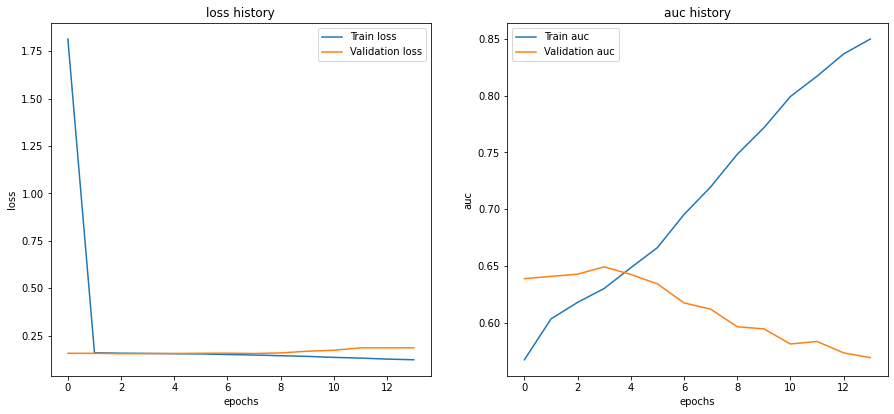

[best epoch is 4]	validation_0-gini_dnn: 0.30045

CV fold 4
Fitting a denoising autoencoder
Epoch 1/50
3721/3721 - 30s - loss: 0.0326 - mse: 0.0326 - mae: 0.0904 - val_loss: 0.0212 - val_mse: 0.0212 - val_mae: 0.0832
Epoch 2/50
3721/3721 - 29s - loss: 0.0226 - mse: 0.0226 - mae: 0.0664 - val_loss: 0.0157 - val_mse: 0.0157 - val_mae: 0.0628
Epoch 3/50
3721/3721 - 29s - loss: 0.0201 - mse: 0.0201 - mae: 0.0580 - val_loss: 0.0118 - val_mse: 0.0118 - val_mae: 0.0540
Epoch 4/50
3721/3721 - 29s - loss: 0.0183 - mse: 0.0183 - mae: 0.0526 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0464
Epoch 5/50
3721/3721 - 34s - loss: 0.0170 - mse: 0.0170 - mae: 0.0486 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0395
Epoch 6/50
3721/3721 - 33s - loss: 0.0161 - mse: 0.0161 - mae: 0.0456 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0329
Epoch 7/50
3721/3721 - 34s - loss: 0.0153 - mse: 0.0153 - mae: 0.0432 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0275
Epoch 8/50
3721/3721 - 34s - loss

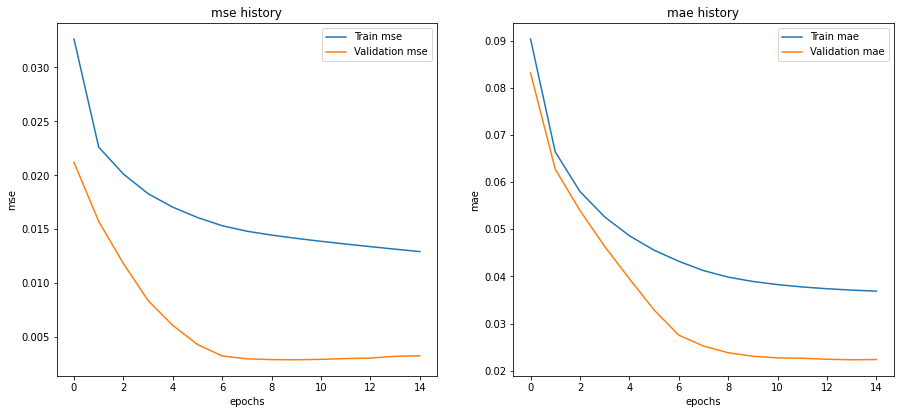

Fitting model
Epoch 1/150
3721/3721 - 16s - loss: 1.9334 - auc: 0.5724 - val_loss: 0.1635 - val_auc: 0.6192
Epoch 2/150
3721/3721 - 16s - loss: 0.1607 - auc: 0.6044 - val_loss: 0.1599 - val_auc: 0.6249
Epoch 3/150
3721/3721 - 15s - loss: 0.1578 - auc: 0.6200 - val_loss: 0.1556 - val_auc: 0.6325
Epoch 4/150
3721/3721 - 16s - loss: 0.1560 - auc: 0.6337 - val_loss: 0.1555 - val_auc: 0.6313
Epoch 5/150
3721/3721 - 15s - loss: 0.1545 - auc: 0.6501 - val_loss: 0.1585 - val_auc: 0.6323
Epoch 6/150
3721/3721 - 15s - loss: 0.1523 - auc: 0.6752 - val_loss: 0.1562 - val_auc: 0.6214
Epoch 7/150
3721/3721 - 16s - loss: 0.1504 - auc: 0.6977 - val_loss: 0.1571 - val_auc: 0.6169
Epoch 8/150
3721/3721 - 15s - loss: 0.1469 - auc: 0.7288 - val_loss: 0.1590 - val_auc: 0.6062
Epoch 9/150
3721/3721 - 15s - loss: 0.1441 - auc: 0.7517 - val_loss: 0.1612 - val_auc: 0.5969
Epoch 10/150
3721/3721 - 16s - loss: 0.1398 - auc: 0.7793 - val_loss: 0.1618 - val_auc: 0.5905
Epoch 11/150
3721/3721 - 15s - loss: 0.1361 -

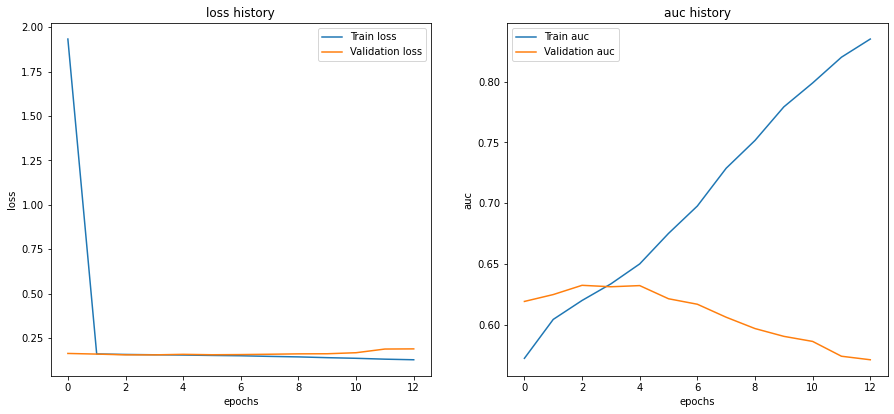

[best epoch is 3]	validation_0-gini_dnn: 0.27007



In [17]:
preds = np.zeros(len(test))
oof = np.zeros(len(train))
metric_evaluations = list()

skf = StratifiedKFold(n_splits=config.cv_folds, shuffle=True, random_state=config.random_state)

for k, (train_idx, valid_idx) in enumerate(skf.split(train, target)):
    print(f"CV fold {k}")
    
    X_train, y_train = train[train_idx, :], target[train_idx]
    X_valid, y_valid = train[valid_idx, :], target[valid_idx]

    if config.reuse_autoencoder:
        print("restoring previously trained dae")
        autoencoder = load_model(f"./dae_fold_{k}")
    else:
        autoencoder = autoencoder_fitting(X_train, X_valid,
                                        filename=f'./dae_fold_{k}', 
                                        random_state=config.random_state)
    
    model, history = model_fitting(X_train, y_train, X_valid, y_valid,
                                autoencoder=autoencoder,
                                filename=f"dnn_model_fold_{k}", 
                                random_state=config.random_state)
    
    val_preds = model.predict(X_valid, batch_size=128)
    best_score = eval_gini(y_true=y_valid, y_pred=np.ravel(val_preds))

    best_epoch = np.argmax(history.history['val_auc']) + 1
    print(f"[best epoch is {best_epoch}]\tvalidation_0-gini_dnn: {best_score:0.5f}\n")
    
    metric_evaluations.append(best_score)
    preds += model.predict(test, batch_size=128).ravel() / skf.n_splits
    oof[valid_idx] = model.predict(X_valid, batch_size=128).ravel()
    
    gpu_cleanup([autoencoder, model])

In [18]:
print(f"DNN CV Gini Normalized Score: {np.mean(metric_evaluations):0.3f} ({np.std(metric_evaluations):0.3f})")

DNN CV Gini Normalized Score: 0.276 (0.015)


In [19]:
submission['target'] = preds
submission.to_csv('dnn_submission.csv')

In [20]:
oofs = pd.DataFrame({'id':train_index, 'target':oof})
oofs.to_csv('dnn_oof.csv', index=False)